## Explore OSM Data API
In this notebook, we will use the OpenStreetMap API to identify exhaustively food outlets in England. Since the research focus will potentially look at both food desert and food swamp, we may be interested in the following:


In [1]:
# import osm package
from OSMPythonTools.api import Api
import osmnx
import contextily as cx 
import folium
import xyzservices.providers as xyz

# import geospatial packages
import geopandas as gpd
import shapely

# import data manipulation modules
import pandas as pd 
import numpy as np 

# import visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# import api keys
from api_keys import stadia_key

## Define Study Area
To extract the amenities location from OSM API, we need to define the boundary box of the study area. In the codes below, we will import the boundaries of England from the ONS API.
To experiment with the OSM API, we will define a smaller boundary box to experiment with the code.

In [2]:
# define the bbox
country_bound_url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Countries_December_2021_GB_BGC_2022/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

gdf_country = gpd.read_file(country_bound_url)
# check the crs
print(f"The current CRS used: EPSG {gdf_country.crs.to_epsg()}")

The current CRS used: EPSG 4326


In [3]:
# define the boundary box using the geography of England
eng_bound = gdf_country.query("CTRY21NM == 'England'")
bbox = eng_bound.bounds
bbox_array = np.array(bbox)[0]

# define an experiment small boundary box
nw3 = np.array([-0.185,51.54,-0.16,51.56])
wc2a = np.array([-0.125, 51.51 ,-0.11, 51.53])

In [4]:
# parse to N, S, E, W
bbox =  wc2a
west, south, east, north = bbox[0],bbox[1],bbox[2],bbox[3]

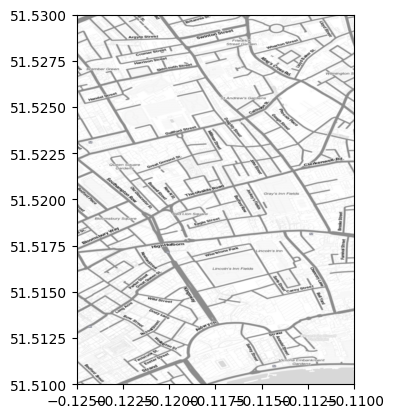

In [5]:
# visualise the arbitary location
fig, ax = plt.subplots()

# set xlim ylim
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# define base map
map_api = "https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=" + stadia_key 
cx.add_basemap(ax, crs="EPSG:4326", source = map_api)

## OSM NX Data
To identify food desert and food swamp, we are intersted in the folowing [amenties](https://wiki.openstreetmap.org/wiki/Key:amenity):

Using the `features_from_bbox`, the API returns a multi-index dataframe of `element_type` > `osmid`. Namely, the results are divided between node (i.e. points) and way (i.e. polygon or multipolygon).
For the purpose of identifying the location of these food outlets, the centroid of the establishment should be sufficient. To identify for the particular type of shops, we need to pass in dictionary to the `tags` parameter. While it is possible to pass one or more attribute to the `tags` parameter, the result is a union of the search.
 
 
There exists multiple ways to filter for the point of interest. In the section below, we will explore by exhaustion the tag that best extract the data of interst.

For example:
* "amenty":"fast_food"

For identifying supermarkets or other healthy food outlets. We could use the [shop](https://wiki.openstreetmap.org/wiki/Foodhttps://wiki.openstreetmap.org/wiki/Food) key
* "building": "Supermarket" – this returns only polygon instances, mostly superstore
* "shop": "bakery"
* "shop": "convenience"
* "shop": "deli"
* "shop": "farm"
* "shop": "food"
* "shop": "frozen_food"
* "shop": "greengrocer"
* "shop": "grocery"
* "shop": "health_food"
* "shop": "seafood"
* "shop": 'supermarket'

### Food Swamp

In [6]:
amenities = osmnx.features_from_bbox(north, south, east,west,
                               tags = {'amenity':"fast_food"}
                               )

# # visualise the arbitary location
# fig, ax = plt.subplots()

# # set xlim ylim
# ax.set_xlim(west, east)
# ax.set_ylim(south, north)

# cx.add_basemap(ax, crs="EPSG:4326")
# amenities.plot(ax = ax)

/var/folders/qy/zxn_2n9d69v1cfcx0cnpg6g00000gn/T/ipykernel_17843/359739956.py:1: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  amenities = osmnx.features_from_bbox(north, south, east,west,


### Food Deserts

In [7]:
# define the tags
tags = ["supermarket","grocery","convenience","health_food"]
amenities = gpd.GeoDataFrame()

try:
    new_data = osmnx.features_from_bbox(bbox = (north,south,east,west),
                                tags = {'shop':tags}
                                )
    print(f"{len(new_data)} shops were located within the boundary")
except:
    print(f'No data point was found for the boundary.')
    
amenities = pd.concat([amenities,new_data], ignore_index = True)
# return the centroid
amenities.geometry = amenities.centroid


45 shops were located within the boundary


/var/folders/qy/zxn_2n9d69v1cfcx0cnpg6g00000gn/T/ipykernel_17843/2419274564.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  amenities.geometry = amenities.centroid


While it is intuitive to use "supermarket" and "grocery" as a key to search for healthy food outlets. However, looking at the area of Hampstead Heath (NW3), it seems that a lot of the express store, including (tesco express, budgens) has been allocated with the tag "convenience".

In [9]:
amenities['shop'].unique()

array(['convenience', 'health_food', 'supermarket'], dtype=object)

In [11]:
m = folium.Map(location=[(north + south)/2, (east + west)/2], zoom_start=15, control_scale = False,
               tiles = map_api, attr = '<a href="https://stadiamaps.com/" target="_blank">Stadia Maps</a>'# change the tile provider
               )

# create cmap
colors = ['red','green','blue']
cmap = dict(zip(amenities['shop'].unique(),colors))

# add the marker
for id, shop in amenities.iterrows():
    location = [shop.geometry.y, shop.geometry.x]
    popup = f"{shop['shop']}: {shop['name']}"
    folium.Marker(location = location, popup = popup,
                  icon = folium.Icon(color = cmap[shop['shop']])) \
            .add_to(m)

display(m)

## Iterate through the England Grid
In the section below, we divide the England boundary into cells of 0.1 in longitude coordinate $\times$ 0.1 latitude coordinate.
The code is executed on 17th Mar 2024

In [12]:
# england bbox
eng_bound.bounds
# define the grid size
y_step = 1 
x_step = 1

# define the study grid
minx = (np.floor(eng_bound.bounds['minx']*10) /10).values[0]
miny = (np.floor(eng_bound.bounds['miny']*10) /10).values[0]
maxx = (np.ceil(eng_bound.bounds['maxx']*10) /10).values[0]
maxy = (np.ceil(eng_bound.bounds['maxy']*10) /10).values[0]

# instantiate empty
tags = ["supermarket","grocery","convenience","health_food"]
amenities = gpd.GeoDataFrame()

In [ ]:
n_grid = len(np.arange(minx,maxx, x_step)) * len(np.arange(miny, maxy, y_step))
i=0
for x_i in np.arange(minx,maxx, x_step):
    for y_i in np.arange(miny, maxy, y_step):
        # parse the bbox
        bbox = np.array([y_i, y_i + y_step, x_i, x_i + x_step])
        bbox_geometry = np.array([[x_i,y_i],
                            [x_i + x_step, y_i],
                            [x_i, y_i + y_step],
                            [x_i+ x_step, y_i + y_step]
                            ])
        if (shapely.geometry.Polygon(bbox_geometry).intersects(eng_bound.geometry[0])):
            try:
                new_data = osmnx.features_from_bbox(bbox = bbox,
                                    tags = {'shop':tags}
                                    )
                print(f"{len(new_data)} shops were located within the boundary.")
                amenities = pd.concat([amenities,new_data], ignore_index = True)
            except:
                print(f'No data point was found for {tag} shop')  
            i+=1
            print(f"{i} grid searched.{len(amenities)} retrieved cumulatively.")
            pct = n_grid - i
            print("[" + ("|"*i) + ("-"*pct)+ "]")

In [50]:
cols = ["name","name:en","shop","addr:city","brand","geometry"]
amenities_subset = amenities[cols]

In [51]:
amenities_subset.to_file("./data/amenities_supermarket.geojson", driver="GeoJSON")

<Axes: >

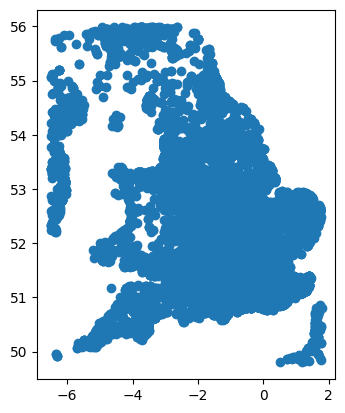

In [52]:
amenities_subset.plot()